In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LinearRegression

In [2]:
weather_data = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_1_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
X= merged_df[['DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
#X= merged_df[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
#y=merged_df[['DC_POWER']]
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[0.        , 0.32219047, 0.09950559, 0.        ],
       [0.        , 0.32219047, 0.09950559, 0.        ],
       [0.        , 0.32219047, 0.09950559, 0.        ],
       ...,
       [0.        , 0.10170895, 0.0482553 , 0.        ],
       [0.        , 0.10170895, 0.0482553 , 0.        ],
       [0.        , 0.10170895, 0.0482553 , 0.        ]])

In [3]:
X.shape

(68774, 4)

In [4]:
input_layer = Input(shape =(X.shape[1], ))

encoded = Dense(3, activation ='tanh', activity_regularizer = regularizers.l1(10e-5))(input_layer)

output_layer = Dense(X.shape[1], activation ='sigmoid')(encoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adam", loss ="mse")

History=autoencoder.fit(X_scaled, X_scaled,batch_size = 100, epochs = 50,shuffle = True, validation_split = 0.10)

Epoch 1/50
619/619 [==============================] - 3s 4ms/step - loss: 0.1069 - val_loss: 0.0178
Epoch 2/50
619/619 [==============================] - 1s 993us/step - loss: 0.0152 - val_loss: 0.0042
Epoch 3/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 4/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 6/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/50
619/619 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 9.4597e-04
Epoch 10/50
619/619 [==============================] - 1s 995us/step - loss: 0.0013 - val_loss

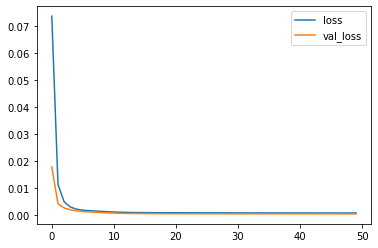

In [5]:
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [6]:
encoded_train_data=autoencoder.predict(X_scaled)
scaled_train_features = pd.DataFrame(encoded_train_data, index=X.index, columns=X.columns)
X_scaled_df=pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
train_mae_loss = np.mean((X_scaled_df - scaled_train_features)**2, axis=1)
train_mae_loss

0        0.000172
1        0.000172
2        0.000172
3        0.000172
4        0.000172
           ...   
68769    0.000164
68770    0.000164
68771    0.000164
68772    0.000164
68773    0.000164
Length: 68774, dtype: float64

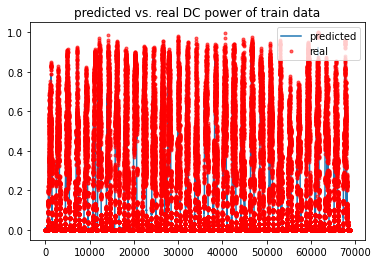

In [7]:
%matplotlib inline
# plt.figure(figsize=(15, 10))
plt.plot(scaled_train_features.DC_POWER, label='predicted')
plt.plot(X_scaled_df.DC_POWER,  'r.', alpha=0.6,label='real')
plt.title('predicted vs. real DC power of train data')
plt.legend()
plt.show()

In [8]:
merged_err=merged_df.join(pd.DataFrame(train_mae_loss))
merged_err.rename(columns={0: 'ERROR'}, inplace=True)
merged_err.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR,ERROR
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000172
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000172
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000172
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000172
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000172


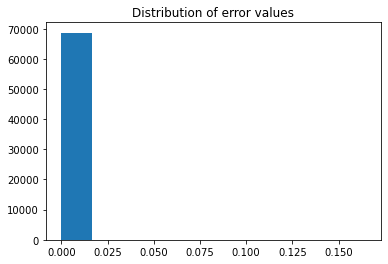

In [9]:
plt.hist(merged_err['ERROR'])
plt.title('Distribution of error values')
plt.show()

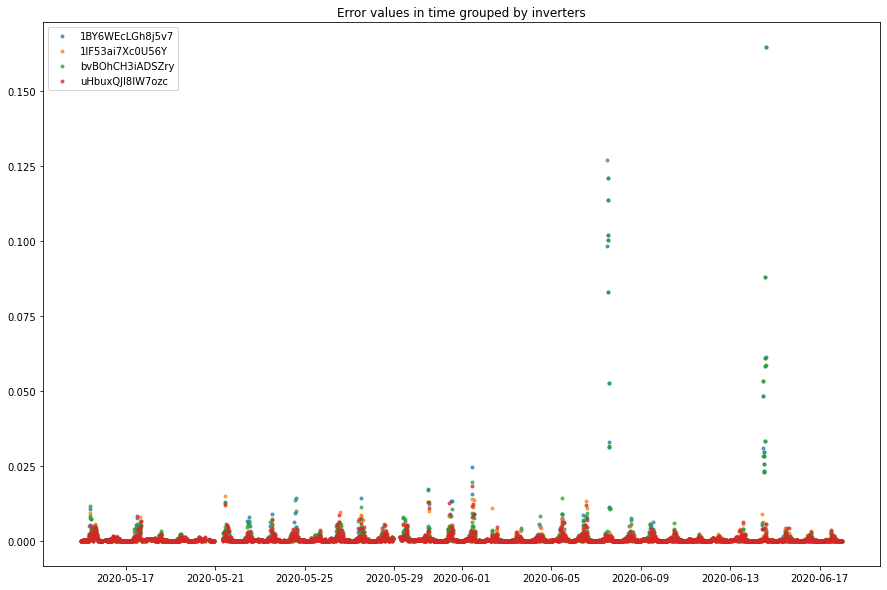

In [10]:
plt.figure(figsize=(15, 10))
for i, inv in merged_err.groupby(merged_err.SOURCE_KEY):
    if (i=='1BY6WEcLGh8j5v7')|(i=='bvBOhCH3iADSZry')|(i=='1IF53ai7Xc0U56Y')|(i=='uHbuxQJl8lW7ozc'):
        plt.plot_date(inv.DATE_TIME, inv.ERROR,'.', label=i, alpha=0.7)
#     plt.show()
plt.legend()
plt.title('Error values in time grouped by inverters')
plt.show()

In [27]:
def get_outliers_in_time(data, column, groupby_column, output_column_name=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    for i, group in  data.groupby(data[groupby_column]):
        outlier_condition1=group[column]>(group[column].mean() + outlier_limit*group[column].std())
        outlier_condition2=group[column]<(group[column].mean() - outlier_limit*group[column].std())
        data.loc[group[outlier_condition1|outlier_condition2].index, output_column_name]=1
    return data
def get_outlier_errors(data, column, output_column_name=False, outlier_limit=3, window='7d'):
    cleaned_column='cleaned'
    if output_column_name==False:
        output_column_name=column+"_outliers"
    resorted=data.set_index('DATE_TIME').copy()
    resorted[cleaned_column]=np.where(resorted[column]>0, resorted[column], np.nan)
    resorted[output_column_name]=0
    num=resorted.SOURCE_KEY.nunique()
    outlier_condition1= resorted[cleaned_column]>resorted[cleaned_column].rolling(window=window, min_periods=num*8*4).mean()+outlier_limit*resorted[cleaned_column].rolling(window=window, min_periods=num*8*4).std()
    resorted.loc[outlier_condition1, output_column_name]=1
    return resorted.drop(columns=[cleaned_column]).reset_index()

In [42]:
merged_outliers=get_outlier_errors(merged_err, 'ERROR', output_column_name="alarm_error_outlier", outlier_limit=10)

In [43]:
merged_dc_outlier=get_outliers_in_time(merged_outliers, 'DC_POWER', 'HOUR', output_column_name="alarm_DC_conversion_outlier", outlier_limit=3)

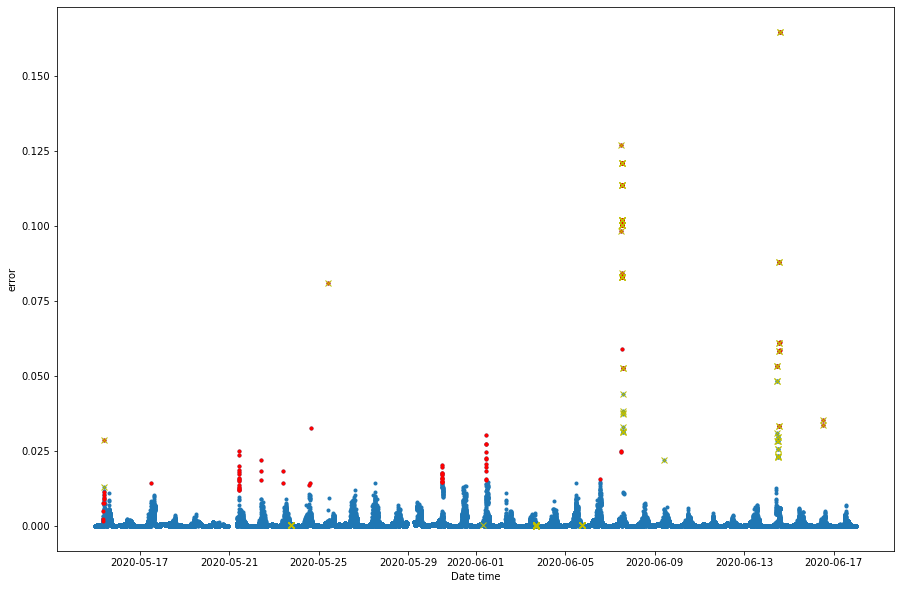

In [44]:
plt.figure(figsize=(15, 10))
plt.plot(merged_dc_outlier['DATE_TIME'], merged_dc_outlier['ERROR'], '.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_error_outlier"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_error_outlier"]==1]['ERROR'], 'r.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['ERROR'], 'yx')
#plt.plot(merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['DATE_TIME'], 
#         merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['ERROR'], 'gx')
plt.xlabel('Date time')
plt.ylabel('error')
plt.show()

###### We can see that the high error rates are mainly caused by the errors that happen during Irradiation to DC and DC to AC conversions.

## 2. Inverter level efficiency
#### a) Take the mean of the reconstruction error for each inverter after removing the outliers

In [45]:
print(merged_outliers[merged_outliers.alarm_error_outlier == 1].shape)
clean_data=merged_outliers.copy()
print(clean_data.shape)
clean_data.drop(clean_data.loc[clean_data.alarm_error_outlier == 1].index, inplace=True)
print(clean_data.shape)  

(111, 19)
(68774, 19)
(68663, 19)


In [46]:
def inverter_error(data):
    mean_error=[]
    inverters=[]
    for i, inv in data.groupby(data.SOURCE_KEY):
        ind = inv[inv['SOURCE_KEY']==i].index.values
        m = inv.ERROR.mean()
        mean_error.append(m)
        inverters.append(i)
    inv_error_df = pd.DataFrame(data=np.array(mean_error), columns=['MEAN_ERROR'])
    source_key = pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
    inv_error_df['SOURCE_KEY'] = source_key['SOURCE_KEY']
    return(inv_error_df)

In [47]:
inv_error_df=inverter_error(clean_data)
inv_error_df.head()

,MEAN_ERROR,SOURCE_KEY
0,0.000713,1BY6WEcLGh8j5v7
1,0.000561,1IF53ai7Xc0U56Y
2,0.000601,3PZuoBAID5Wc2HD
3,0.000530,7JYdWkrLSPkdwr4
4,0.000557,McdE0feGgRqW7Ca


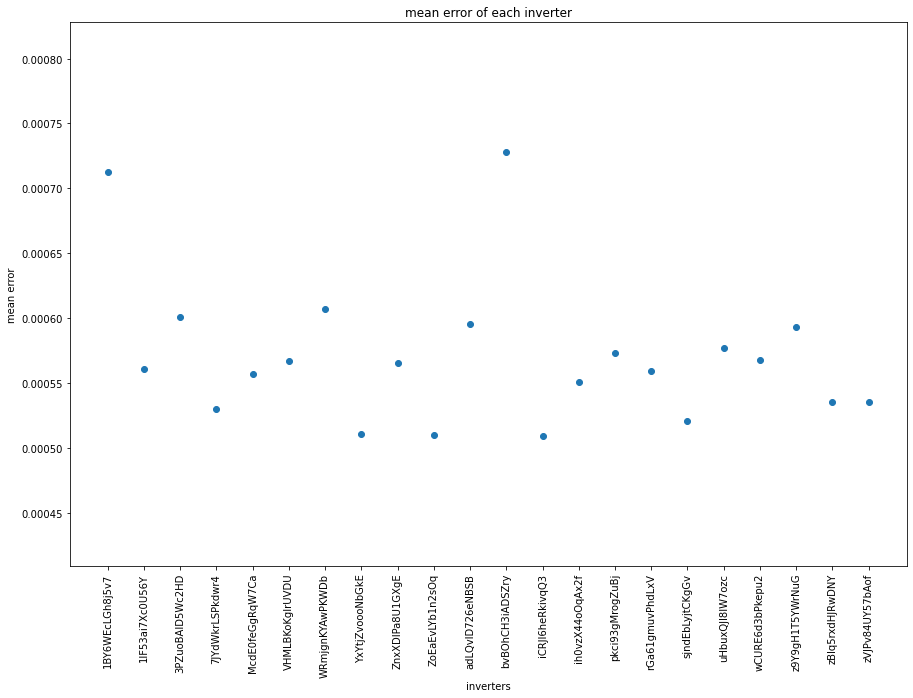

In [48]:
plt.figure(figsize=(15, 10))
plt.scatter(inv_error_df.SOURCE_KEY,inv_error_df.MEAN_ERROR)
plt.xticks(rotation=90) 
plt.ylim(inv_error_df.MEAN_ERROR.min()-0.0001,inv_error_df.MEAN_ERROR.max()+0.0001)
plt.xlabel('inverters')
plt.ylabel('mean error')
plt.title('mean error of each inverter')
plt.show()

#### b) Calculate a mean reconstruction error per inverter per day and then compare those mean values to find inverters with higher mean reconstruction error in a single day and then over several days.

In [49]:
def daily_inverter_error(data):
    mean_error=[]
    inverters=[]
    days=[]
    for a, day in data.groupby(data.DAY):
        for i, inv in day.groupby(day.SOURCE_KEY):
            ind = inv[inv['SOURCE_KEY']==i].index.values
            m = inv.ERROR.mean()
            mean_error.append(m)
            inverters.append(i)
            days.append(a)
    inv_error_df = pd.DataFrame(data=np.array(mean_error), columns=['MEAN_ERROR'])
    source_key = pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
    Days = pd.DataFrame(data=np.array(days), columns=['DAY'])
    inv_error_df['SOURCE_KEY'] = source_key['SOURCE_KEY']
    inv_error_df['DAY']=Days['DAY']
    return(inv_error_df)

In [50]:
daily_inv_error_df=daily_inverter_error(clean_data)
daily_inv_error_df

,MEAN_ERROR,SOURCE_KEY,DAY
0,0.001103,1BY6WEcLGh8j5v7,136
1,0.000986,1IF53ai7Xc0U56Y,136
2,0.001158,3PZuoBAID5Wc2HD,136
3,0.001001,7JYdWkrLSPkdwr4,136
4,0.000954,McdE0feGgRqW7Ca,136
...,...,...,...
743,0.000325,uHbuxQJl8lW7ozc,169
744,0.000293,wCURE6d3bPkepu2,169
745,0.000272,z9Y9gH1T5YWrNuG,169
746,0.000298,zBIq5rxdHJRwDNY,169


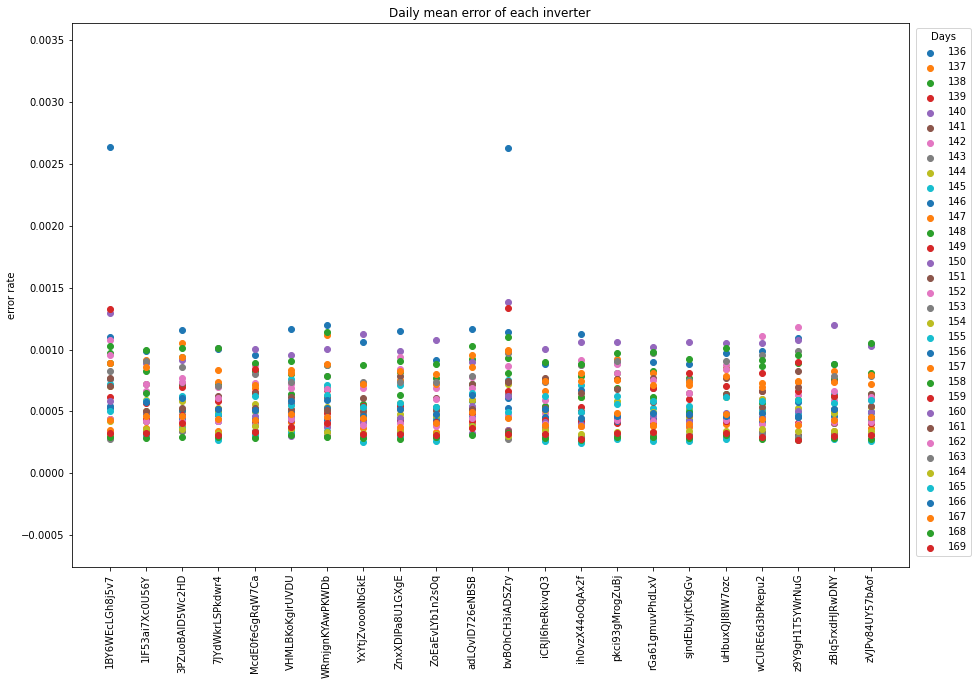

In [51]:
plt.figure(figsize=(15, 10))
for i, day in daily_inv_error_df.groupby(daily_inv_error_df.DAY):
    plt.scatter(day.SOURCE_KEY, day.MEAN_ERROR, label=i)
plt.xticks(rotation=90)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.001,daily_inv_error_df.MEAN_ERROR.max()+0.001)
plt.ylabel('error rate')
plt.legend(loc="upper right", title="Days", bbox_to_anchor=(1.08, 1))
plt.title('Daily mean error of each inverter')
plt.show()

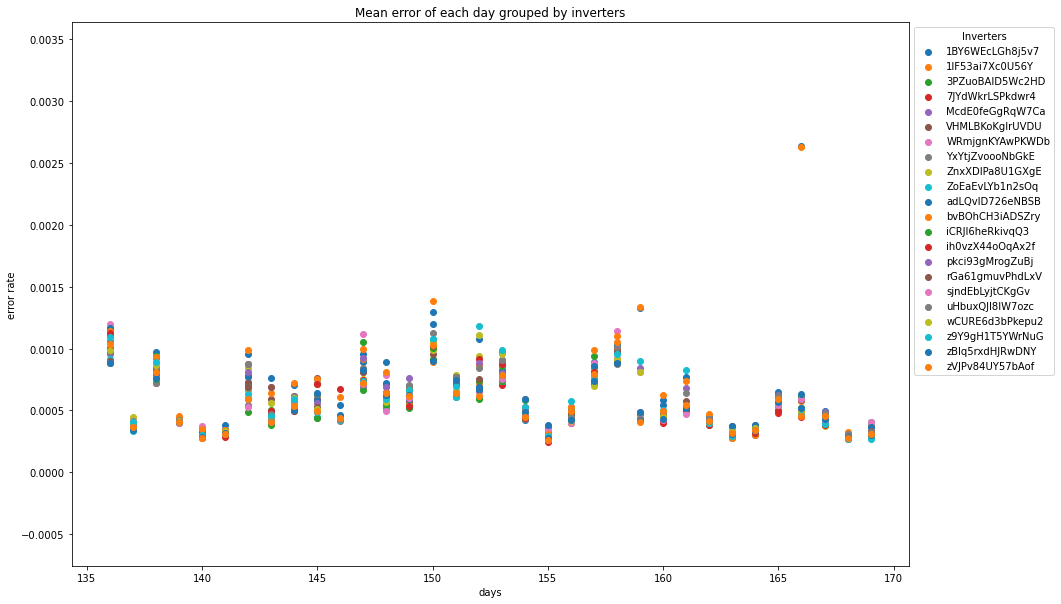

In [52]:
plt.figure(figsize=(15, 10))
for i, inv in daily_inv_error_df.groupby(daily_inv_error_df.SOURCE_KEY):
    plt.scatter(inv.DAY, inv.MEAN_ERROR, label=i)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.001,daily_inv_error_df.MEAN_ERROR.max()+0.001)
plt.ylabel('error rate')
plt.xlabel('days')
plt.legend(loc="upper right", title="Inverters", bbox_to_anchor=(1.18, 1))
plt.title('Mean error of each day grouped by inverters')
plt.show()

In [53]:
def get_inefficient_inverters_day(data, column, output_column_name, anomaly_limit = 2):
    data[output_column_name] = 0
    for _,d in data.groupby('DAY'):
        col_mean = d[column].mean()
        col_std = d[column].std()
        data.loc[d[(d[column] > col_mean + anomaly_limit * col_std)].index,output_column_name] = 1
    return data
def get_inefficient_inverters_window(data, column, output_column_name, window=7):
    data[output_column_name] = 0
    for inv in data['SOURCE_KEY'].unique():
        data.loc[data['SOURCE_KEY']==inv, output_column_name]=data[data['SOURCE_KEY']==inv][column].rolling(window = window).min()
    return data

Text(0, 0.5, 'DC conversion coefficient')

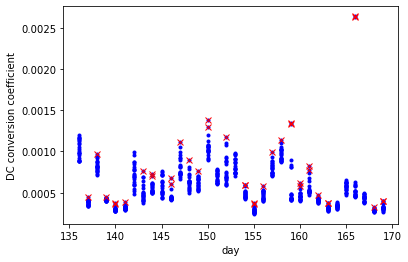

In [54]:
daily_inv_error_df = get_inefficient_inverters_day(daily_inv_error_df, 'MEAN_ERROR', 'alarm_inefficient_inverter_day')
data=daily_inv_error_df
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['MEAN_ERROR'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_day==1]['DAY'], data[data.alarm_inefficient_inverter_day==1]['MEAN_ERROR'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [55]:
daily_inv_error_df[daily_inv_error_df['alarm_inefficient_inverter_day']==1]

,MEAN_ERROR,SOURCE_KEY,DAY,alarm_inefficient_inverter_day
30,0.000444,ZnxXDlPa8U1GXgE,137,1
44,0.000974,1BY6WEcLGh8j5v7,138,1
77,0.000451,bvBOhCH3iADSZry,139,1
90,0.000359,3PZuoBAID5Wc2HD,140,1
94,0.000370,WRmjgnKYAwPKWDb,140,1
120,0.000382,adLQvlD726eNBSB,141,1
154,0.000762,1BY6WEcLGh8j5v7,143,1
176,0.000703,1BY6WEcLGh8j5v7,144,1
187,0.000721,bvBOhCH3iADSZry,144,1
231,0.000610,bvBOhCH3iADSZry,146,1
